

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



**Data feature & description**: The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant. The data set contains the following diseases: Actinic keratosis, Basal cell carcinoma, Dermatofibroma, Melanoma, Nevus, Pigmented benign keratosis, Seborrheic keratosis, Squamous cell carcinoma and Vascular lesion.



In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install Augmentor

In [47]:
#Importing required Libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
import os
import cv2
import shutil
import Augmentor
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

**Data Reading/Data Understanding**→ Defining the path for train and test images

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Test')

In [7]:
# Count the number of images in the training dataset
# data_dir_train is a pathlib.Path object pointing to the training data directory
# The glob('*/*.jpg') method finds all .jpg files in the subdirectories of data_dir_train
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Count the number of images in the Validation dataset
# data_dir_test is a pathlib.Path object pointing to the testing data directory
# The glob('*/*.jpg') method finds all .jpg files in the subdirectories of data_dir_test
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


**Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.**

In [8]:
#Define some parameters for the dataset
batch_size = 32
img_height = 180
img_width = 180

In [9]:
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2551 files belonging to 9 classes.
Using 2041 files for training.


In [10]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2551 files belonging to 9 classes.
Using 510 files for validation.


In [11]:
# Print the class names
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
# Print the type of the 'train_ds' object
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


**Dataset visualisation** → Create a code to visualize one instance of all the nine classes present in the dataset

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
32
32


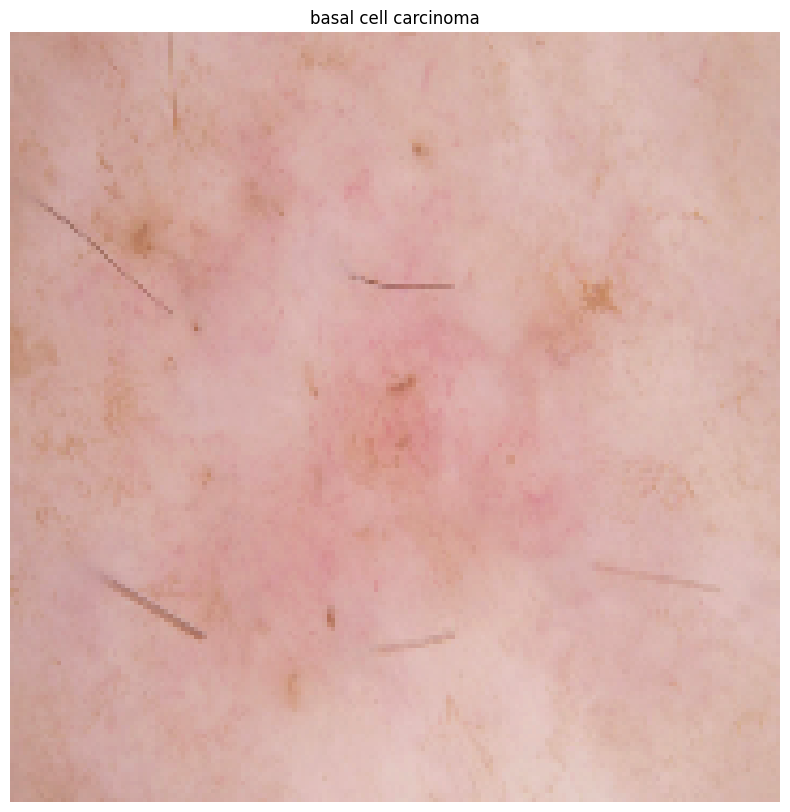

In [13]:
# Define the class names variable
class_names = train_ds.class_names

# Print the class names
print(class_names)


# Visualising one instance of image from each of the 9 class:
plt.figure(figsize=(10, 10))  # Set the figure size for the plot
for images, labels in train_ds.take(1):  # Take one batch of images and labels from the training dataset
  print(len(images))  # Print the number of images in the batch
  print(len(labels))  # Print the number of labels in the batch
  plt.imshow(images[10].numpy().astype("uint8"))  # Display the 11th image in the batch
  plt.title(class_names[labels[10]])  # Set the title of the plot to the class name of the 11th image
  plt.axis("off")  # Turn off the axis



**Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset**

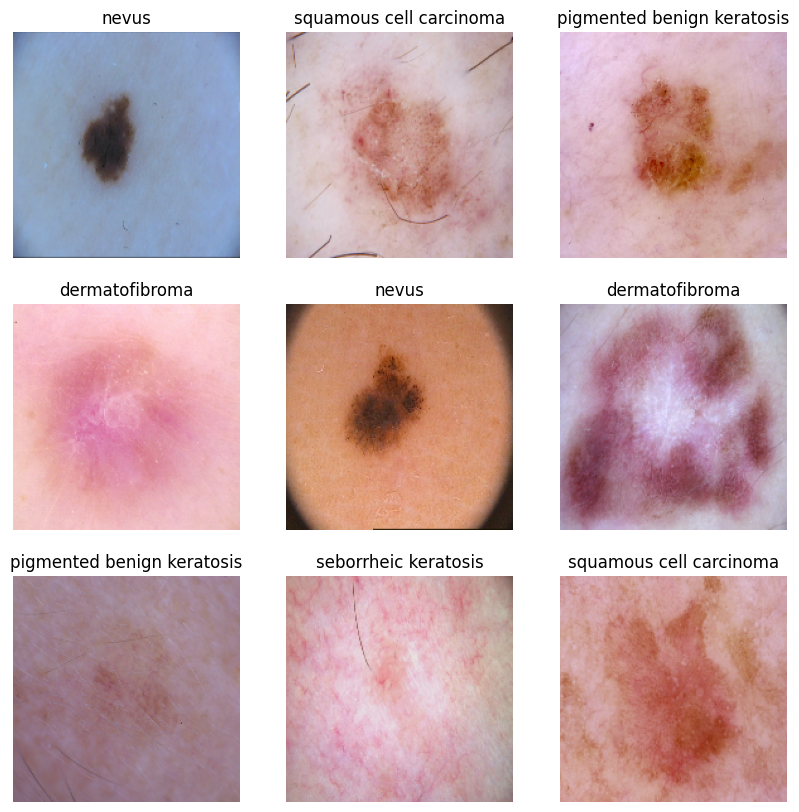

In [14]:
# Step 3: Dataset Visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

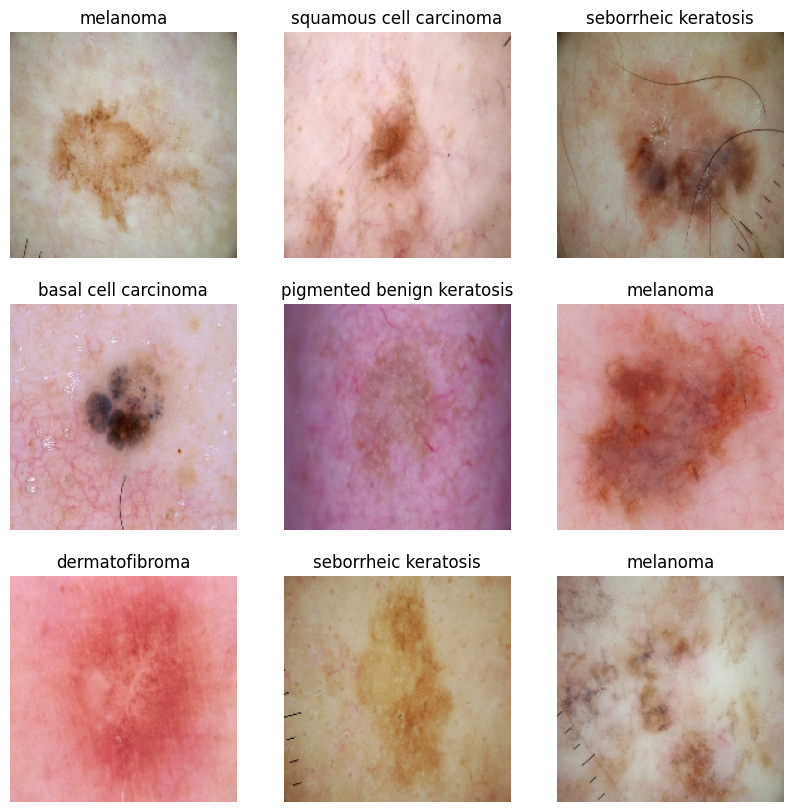

In [15]:
# Visualize a batch of images from the validation dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):  # Take a single batch from the validation dataset
    for i in range(9):  # Display the first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert image to uint8 type for display
        plt.title(class_names[labels[i]])  # Display the class name as the title
        plt.axis("off")  # Remove axis
plt.show()


**Model Building & training** :
1. Create a CNN model, which can accurately detect 9 classes present in
the dataset.
2. While building the model, rescale images to normalize pixel values between (0,1).
3. Choose an appropriate optimiser and loss function for model training
4. Train the model for ~20 epochs
5. Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [16]:
#overlaps data preprocessing and model execution while training., Speed up training

# Import AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Apply caching, shuffling, and prefetching to the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply caching and prefetching to the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


To speed up training by overlapping data preprocessing and model execution, we can utilize TensorFlow's data pipeline optimization features such as caching, shuffling, and prefetching. The AUTOTUNE option helps to tune the performance automatically.

1. Cache the dataset: This stores the data in memory after the first epoch, so it's quicker in subsequent epochs.
2. Shuffle the dataset: This is important to ensure the data is mixed well before training.
3. Prefetch the dataset: This overlaps data preprocessing and model execution to improve performance.

In [17]:
# Define the CNN model
from tensorflow.keras.layers import Rescaling

num_class = 9

model = Sequential(name='Sequential_Model')

model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3), name='Rescaling_Layer'))

# Or we can specify using below commands separately
#model.add(layers.Input(shape=(img_height,img_width,3)))
#model.add(layers.Rescaling(scale=1./255))

model.add(layers.Conv2D(filters= 16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1_Layer'))
model.add(layers.MaxPooling2D(name='MaxPooling_1_Layer'))

model.add(layers.Conv2D(filters= 32, kernel_size=3, padding='same', activation='relu', name='Conv2D_2_Layer'))
model.add(layers.MaxPooling2D(name='MaxPooling_2_Layer'))

model.add(layers.Conv2D(filters= 64, kernel_size=3, padding='same', activation='relu', name='Conv2D_3_Layer'))
model.add(layers.MaxPooling2D(name='MaxPooling_3_Layer'))

model.add(layers.Flatten(name='Flatten_Layer'))
model.add(layers.Dense(units=128, activation='relu', name='Dense-1_Layer'))
model.add(layers.Dense(units=9, name='Dense-2_Layer'))


In [18]:
# View the summary of all layers
model.summary()

Model: "Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 Conv2D_1_Layer (Conv2D)     (None, 180, 180, 16)      448       
                                                                 
 MaxPooling_1_Layer (MaxPoo  (None, 90, 90, 16)        0         
 ling2D)                                                         
                                                                 
 Conv2D_2_Layer (Conv2D)     (None, 90, 90, 32)        4640      
                                                                 
 MaxPooling_2_Layer (MaxPoo  (None, 45, 45, 32)        0         
 ling2D)                                                         
                                                  

In [19]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = opt,
              loss = loss_fn,
              metrics = ['accuracy'])

**Train the model**

In [20]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 170s 299ms/step - loss: 1.8148 - accuracy: 0.3008 - val_loss: 1.5964 - val_accuracy: 0.3863
Epoch 2/20
64/64 [==============================] - 1s 20ms/step - loss: 1.5057 - accuracy: 0.4454 - val_loss: 1.5791 - val_accuracy: 0.4176
Epoch 3/20
64/64 [==============================] - 1s 20ms/step - loss: 1.3422 - accuracy: 0.5007 - val_loss: 1.4943 - val_accuracy: 0.4451
Epoch 4/20
64/64 [==============================] - 1s 20ms/step - loss: 1.2290 - accuracy: 0.5370 - val_loss: 1.4670 - val_accuracy: 0.4725
Epoch 5/20
64/64 [==============================] - 1s 20ms/step - loss: 1.1400 - accuracy: 0.5718 - val_loss: 1.4793 - val_accuracy: 0.4784
Epoch 6/20
64/64 [==============================] - 1s 20ms/step - loss: 1.0393 - accuracy: 0.6100 - val_loss: 1.5321 - val_accuracy: 0.4804
Epoch 7/20
64/64 [==============================] - 1s 20ms/step - loss: 0.9564 - accuracy: 0.6467 - val_loss: 1.4818 - val_accuracy: 0.4843
Epoch 8/20

**Visualising the Results**



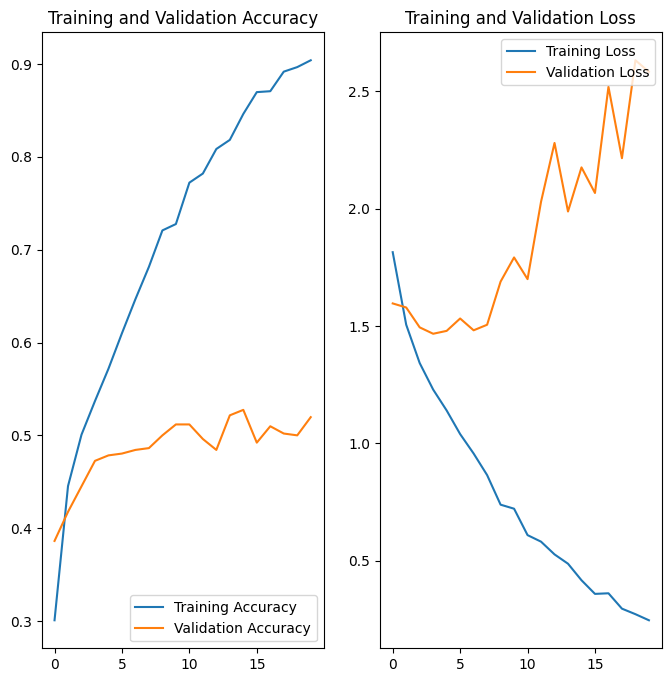

In [21]:
# Define the number of epochs
epochs = 20

# Extract loss and accuracy from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range for the number of epochs
epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()


**The model is currently not performing well, as indicated by the significant disparity between training and validation accuracy. This issue suggests that the model might be overfitting or underfitting. Overfitting occurs when the model performs well on the training data but poorly on the validation data, while underfitting happens when the model does not perform well even on the training data.**
The training accuracy shows a consistent increase, surpassing 0.90 by the end of 20 epochs. However, the validation accuracy initially rises but then fluctuates without any upward trend, stabilizing around 0.51.

The training loss steadily declines, reaching a low value by the end of 20 epochs. In contrast, the validation loss initially decreases but then starts to rise towards the end of the training period.

The significant gap between training and validation accuracy, coupled with the rising validation loss while the training loss continues to decrease, indicates that the model is overfitting.

# Model 2 : Model with implementation of Data Augmentation without Dropout.

In [22]:
aug_model = Sequential(name='CNN-Model-with-Random_Image_Augmentation')

aug_model.add(layers.Rescaling(1./255, input_shape = (img_height, img_width, 3), name='Rescaling_Layer'))

# Using Data Augmentation Layers eg. RandomCrop, Flip, Translate, Rotate etc.
aug_model.add(layers.RandomCrop(img_height, img_width, name='RandomCrop_Layer'))
aug_model.add(layers.RandomFlip(name='RandomFlip_Layer'))
aug_model.add(layers.RandomTranslation(.8,.7, fill_mode='reflect', name='RandomTranslation_Layer'))
aug_model.add(layers.RandomRotation(0.3, name='RandomRotation_Layer'))
aug_model.add(layers.RandomZoom(0.4, name='RandomZoom_Layer'))

aug_model.add(layers.Conv2D(16, 3, padding='same', activation='relu', name='Conv_1_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_1_Layer'))

aug_model.add(layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_2_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_2_Layer'))

aug_model.add(layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_3_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_3_Layer'))

aug_model.add(layers.Flatten(name='Flatten_Layer'))
aug_model.add(layers.Dense(units=128, activation='relu', name='Dense-1_Layer'))
aug_model.add(layers.Dense(units=9, name='Dense-2_Layer'))

aug_model.summary()

Model: "CNN-Model-with-Random_Image_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 RandomCrop_Layer (RandomCr  (None, 180, 180, 3)       0         
 op)                                                             
                                                                 
 RandomFlip_Layer (RandomFl  (None, 180, 180, 3)       0         
 ip)                                                             
                                                                 
 RandomTranslation_Layer (R  (None, 180, 180, 3)       0         
 andomTranslation)                                               
                                                                 
 RandomRotation_Layer (Ran

In [23]:
#Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
aug_model.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])

In [24]:
#Training the model
aug_model_fitted =  aug_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 4s 29ms/step - loss: 2.0731 - accuracy: 0.2229 - val_loss: 1.8021 - val_accuracy: 0.3412
Epoch 2/20
64/64 [==============================] - 2s 24ms/step - loss: 1.7828 - accuracy: 0.3038 - val_loss: 1.7222 - val_accuracy: 0.3255
Epoch 3/20
64/64 [==============================] - 2s 24ms/step - loss: 1.6448 - accuracy: 0.3474 - val_loss: 1.6867 - val_accuracy: 0.3078
Epoch 4/20
64/64 [==============================] - 2s 24ms/step - loss: 1.5774 - accuracy: 0.3836 - val_loss: 1.6335 - val_accuracy: 0.3216
Epoch 5/20
64/64 [==============================] - 1s 23ms/step - loss: 1.5677 - accuracy: 0.3964 - val_loss: 1.6245 - val_accuracy: 0.3255
Epoch 6/20
64/64 [==============================] - 2s 24ms/step - loss: 1.5602 - accuracy: 0.3929 - val_loss: 1.6745 - val_accuracy: 0.3490
Epoch 7/20
64/64 [==============================] - 2s 24ms/step - loss: 1.5957 - accuracy: 0.3797 - val_loss: 1.6709 - val_accuracy: 0.3412
Epoch 8/20
64

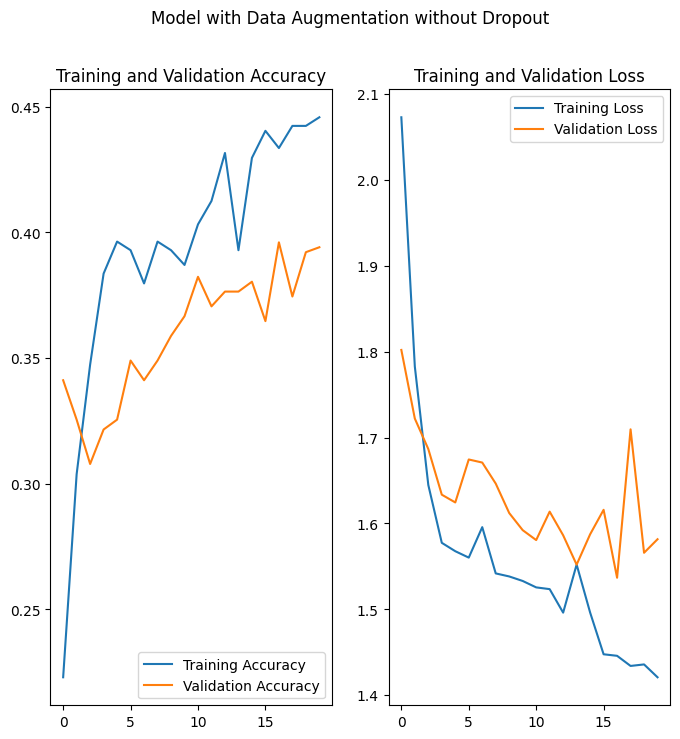

In [25]:
#visualising the result
acc = aug_model_fitted.history['accuracy']
val_acc = aug_model_fitted.history['val_accuracy']

loss = aug_model_fitted.history['loss']
val_loss = aug_model_fitted.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.suptitle('Model with Data Augmentation without Dropout')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy shows a steady increase, surpassing 0.44 by the end of 20 epochs. In contrast, the validation accuracy initially improves but then fluctuates without a consistent upward trend, stabilizing around 0.39.
Similarly, the training loss demonstrates a consistent decline, reaching a low value by the end of the 20 epochs. However, the validation loss initially decreases but begins to rise again towards the end of the training period.

# Model 3 : Model with Data Augmentation and Dropout.

In [26]:
aug_model = Sequential(name='CNN-Model-with-Random_Image_Augmentation-and-Dropout')

aug_model.add(layers.Rescaling(1./255, input_shape = (img_height, img_width, 3), name='Rescaling_Layer'))

# Using Data Augmentation Layers eg. RandomCrop, Flip, Translate, Rotate etc.
aug_model.add(layers.RandomCrop(img_height, img_width, name='RandomCrop_Layer'))
aug_model.add(layers.RandomFlip(name='RandomFlip_Layer'))
aug_model.add(layers.RandomTranslation(.8,.7, fill_mode='reflect', name='RandomTranslation_Layer'))
aug_model.add(layers.RandomRotation(0.3, name='RandomRotation_Layer'))
aug_model.add(layers.RandomZoom(0.4, name='RandomZoom_Layer'))

aug_model.add(layers.Conv2D(16, 3, padding='same', activation='relu', name='Conv_1_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_1_Layer'))

aug_model.add(layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_2_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_2_Layer'))

aug_model.add(layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_3_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_3_Layer'))

aug_model.add(layers.Flatten(name='Flatten_Layer'))
aug_model.add(layers.Dense(units=128, activation='relu', name='Dense-1_Layer'))
aug_model.add(layers.Dropout(0.2, name='Dropout'))
aug_model.add(layers.Dense(units=9, name='Dense-2_Layer'))

aug_model.summary()



Model: "CNN-Model-with-Random_Image_Augmentation-and-Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 RandomCrop_Layer (RandomCr  (None, 180, 180, 3)       0         
 op)                                                             
                                                                 
 RandomFlip_Layer (RandomFl  (None, 180, 180, 3)       0         
 ip)                                                             
                                                                 
 RandomTranslation_Layer (R  (None, 180, 180, 3)       0         
 andomTranslation)                                               
                                                                 
 RandomRotatio

In [27]:
#compile the model
epochs = 20
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

aug_model.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])
# Fit the model
aug_model_fitted =  aug_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 5s 29ms/step - loss: 2.0148 - accuracy: 0.2131 - val_loss: 1.7489 - val_accuracy: 0.3078
Epoch 2/20
64/64 [==============================] - 2s 24ms/step - loss: 1.7317 - accuracy: 0.3038 - val_loss: 1.7363 - val_accuracy: 0.2980
Epoch 3/20
64/64 [==============================] - 1s 23ms/step - loss: 1.6908 - accuracy: 0.3302 - val_loss: 2.0122 - val_accuracy: 0.2490
Epoch 4/20
64/64 [==============================] - 1s 23ms/step - loss: 1.6775 - accuracy: 0.3293 - val_loss: 1.7087 - val_accuracy: 0.2765
Epoch 5/20
64/64 [==============================] - 1s 23ms/step - loss: 1.6464 - accuracy: 0.3439 - val_loss: 1.6213 - val_accuracy: 0.3471
Epoch 6/20
64/64 [==============================] - 2s 24ms/step - loss: 1.6424 - accuracy: 0.3631 - val_loss: 1.7190 - val_accuracy: 0.3451
Epoch 7/20
64/64 [==============================] - 2s 24ms/step - loss: 1.6305 - accuracy: 0.3640 - val_loss: 1.6792 - val_accuracy: 0.3059
Epoch 8/20
64

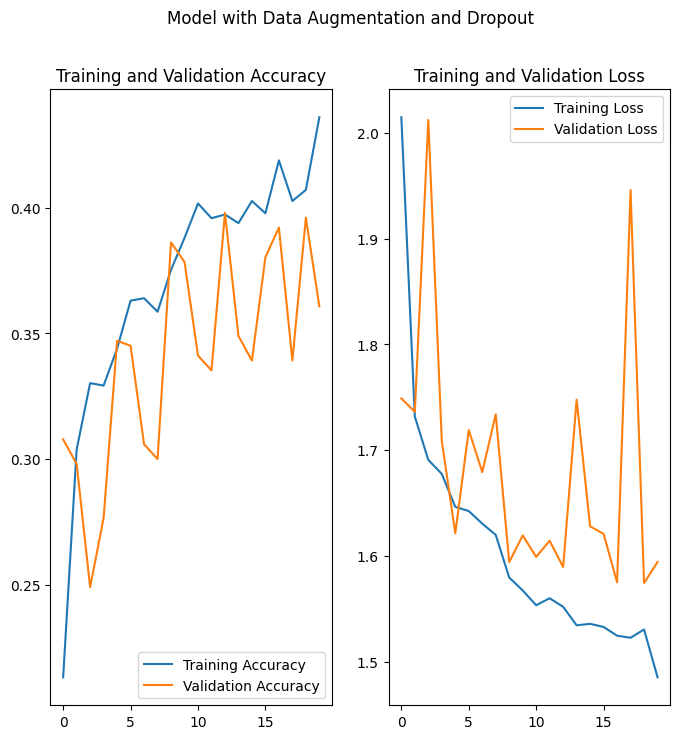

In [28]:
acc = aug_model_fitted.history['accuracy']
val_acc = aug_model_fitted.history['val_accuracy']

loss = aug_model_fitted.history['loss']
val_loss = aug_model_fitted.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.suptitle('Model with Data Augmentation and Dropout')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

he training accuracy shows a steady increase, reaching 0.44 by the end of 20 epochs. In contrast, the validation accuracy shows an initial increase but then fluctuates without a consistent upward trend, stabilizing around 0.36.

Similarly, the training loss demonstrates a consistent decline, reaching a low value by the end of 20 epochs. However, the validation loss initially decreases but begins to rise again towards the end of the training period.

# Model 4 : Model having higher Neurons in each layer with implementation of Data Augmentation and Dropout.

In [30]:
aug_model = Sequential(name='CNN-Model-with-Random_Image_Augmentation-Higher_neurons')

aug_model.add(layers.Rescaling(1./255, input_shape = (img_height, img_width, 3), name='Rescaling_Layer'))

aug_model.add(layers.RandomCrop(img_height, img_width, name='RandomCrop_Layer'))
aug_model.add(layers.RandomFlip(name='RandomFlip_Layer'))
aug_model.add(layers.RandomTranslation(.8,.7, fill_mode='reflect', name='RandomTranslation_Layer'))
aug_model.add(layers.RandomRotation(0.3, name='RandomRotation_Layer'))
aug_model.add(layers.RandomZoom(0.4, name='RandomZoom_Layer'))

aug_model.add(layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_1_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_1_Layer'))

aug_model.add(layers.Conv2D(128, 3, padding='same', activation='relu', name='Conv_2_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_2_Layer'))

aug_model.add(layers.Conv2D(256, 3, padding='same', activation='relu', name='Conv_3_Layer'))
aug_model.add(layers.MaxPooling2D(name='MaxPooling_3_Layer'))

aug_model.add(layers.Flatten(name='Flatten_Layer'))
aug_model.add(layers.Dense(512, activation='relu', name='Dense-1_Layer'))
aug_model.add(layers.Dropout(0.2))
aug_model.add(layers.Dense(9, activation='softmax', name='Dense-2_Layer'))

aug_model.summary()

Model: "CNN-Model-with-Random_Image_Augmentation-Higher_neurons"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 RandomCrop_Layer (RandomCr  (None, 180, 180, 3)       0         
 op)                                                             
                                                                 
 RandomFlip_Layer (RandomFl  (None, 180, 180, 3)       0         
 ip)                                                             
                                                                 
 RandomTranslation_Layer (R  (None, 180, 180, 3)       0         
 andomTranslation)                                               
                                                                 
 RandomRota

In [31]:
#Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

aug_model.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])

#Fitting the model
aug_model_fitted =  aug_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 14s 144ms/step - loss: 2.4052 - accuracy: 0.1754 - val_loss: 2.0891 - val_accuracy: 0.1667
Epoch 2/20
64/64 [==============================] - 6s 89ms/step - loss: 2.0037 - accuracy: 0.2220 - val_loss: 2.0615 - val_accuracy: 0.1569
Epoch 3/20
64/64 [==============================] - 6s 89ms/step - loss: 1.7910 - accuracy: 0.2989 - val_loss: 1.7747 - val_accuracy: 0.2941
Epoch 4/20
64/64 [==============================] - 6s 89ms/step - loss: 1.6724 - accuracy: 0.3469 - val_loss: 1.8239 - val_accuracy: 0.2804
Epoch 5/20
64/64 [==============================] - 6s 89ms/step - loss: 1.7130 - accuracy: 0.3199 - val_loss: 1.7180 - val_accuracy: 0.3275
Epoch 6/20
64/64 [==============================] - 6s 88ms/step - loss: 1.6400 - accuracy: 0.3704 - val_loss: 1.6712 - val_accuracy: 0.3255
Epoch 7/20
64/64 [==============================] - 6s 89ms/step - loss: 1.5657 - accuracy: 0.3880 - val_loss: 1.8375 - val_accuracy: 0.2961
Epoch 8/20


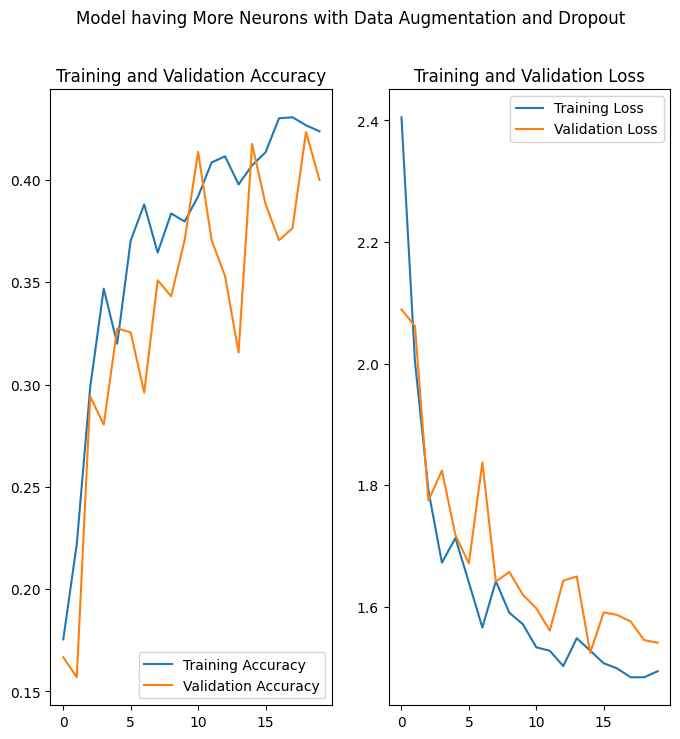

In [32]:
#Visualising the Model 4
acc = aug_model_fitted.history['accuracy']
val_acc = aug_model_fitted.history['val_accuracy']

loss = aug_model_fitted.history['loss']
val_loss = aug_model_fitted.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.suptitle('Model having More Neurons with Data Augmentation and Dropout')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model-2: Model with Data Augmentation w/o Dropout:**

* The gap between training accuracy and validation accuracy has been reduced, indicating that the model is resisting overfitting due to data augmentation.
* Both training loss and validation loss show a steady decline, reaching a low value by the end of 20 epochs.


**Model-3: Model with Data Augmentation with Dropout:**

* The gap between training accuracy and validation accuracy has been further reduced compared to the model without a dropout layer, suggesting that the model's fit is further improved by using the dropout layer.
* Both training loss and validation loss show a steady decline, with fluctuations in validation loss reducing further and reaching a low value below 1.5 by the end of 20 epochs.

**Model-4: Model with More Neurons, Data Augmentation, and Dropout:**

* Fluctuations in both training accuracy and validation accuracy have increased.
* Fluctuations in both training loss and validation loss have also increased.
* This indicates that the model has become more sensitive to the training data, trying to learn more intricate and complex patterns.
* Each epoch is causing significant updates to the weights due to the large number of neurons.
** Conclusion: By using data augmentation, the model seems to underfit, resulting in lower accuracy and higher losses.**







# Checking the Distribution of Classes in the Training Dataset
**Context**: Real-life datasets often exhibit class imbalance, where one class may have a disproportionately higher number of samples compared to others. Class imbalance can negatively impact the quality of the final model. Therefore, it is crucial to perform a sanity check to assess the distribution of classes in the dataset.

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_generator = ImageDataGenerator(rescale=1./255)

train_gen = img_generator.flow_from_directory(data_dir_train, target_size=(img_height, img_width), batch_size=batch_size)

class_dist_train = train_gen.classes
class_dist_train_count = np.bincount(class_dist_train)

class_count_dict = {}

for class_index, count in enumerate(class_dist_train_count):
  class_name = class_names[class_index]
  class_count_dict[class_name] = count

print('Class Distribution is as follows: \n')
class_count_dict

Found 2551 images belonging to 9 classes.
Class Distribution is as follows: 



{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 389,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

- Which class has the least number of samples?

`Answer: seborrheic keratosis`
- Which classes dominate the data in terms proportionate number of samples?

`Answer: pigmented benign keratosis`


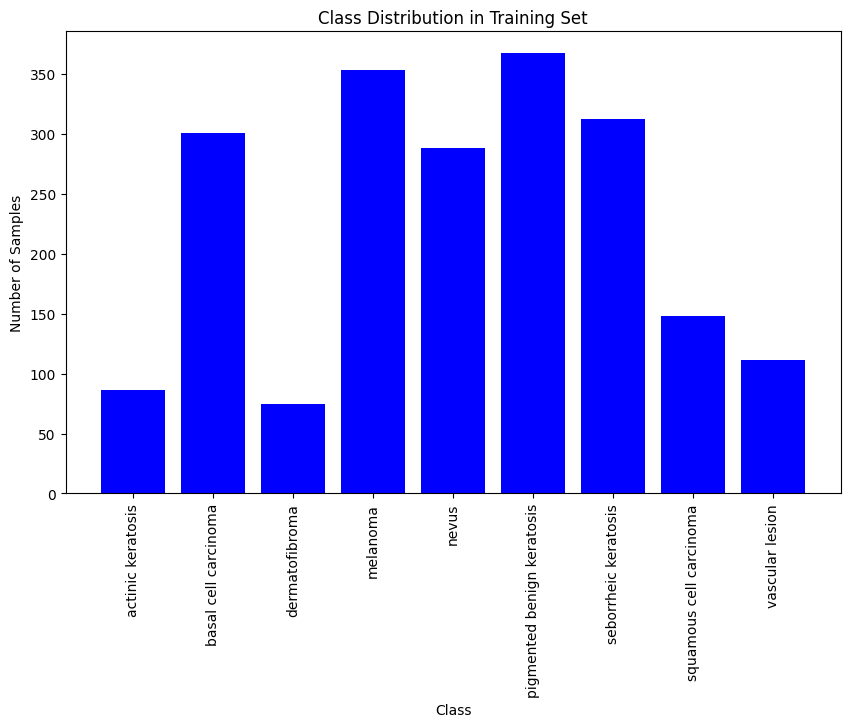

In [34]:
# Count the number of samples per class in the training dataset and
# Plot the class distribution to help identify any imbalances in the dataset
from collections import Counter

# Count samples per class
class_counts = Counter()

for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Convert counts to a list in the order of class_names
class_counts_list = [class_counts[i] for i in range(len(class_names))]

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_list, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()


In [35]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,melanoma,438
2,actinic keratosis,114
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,squamous cell carcinoma,181
6,basal cell carcinoma,376
7,nevus,357
8,vascular lesion,139


**From the class distribution, it is evident that the data is not evenly distributed across the classes.**
It is apparent that the data is imbalanced, with some classes having significantly more images than others. For instance, the classes melanoma and pigmented benign keratosis have the highest number of images, while seborrheic keratosis has the least.
**To address this imbalance and improve model performance, data augmentation techniques will be employed.** Specifically, image rotation will be used to create additional training samples for the underrepresented classes. This approach aims to balance the dataset and prevent the model from becoming biased towards classes with more images.

# Rectifying the class imbalance

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install -q Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [48]:
import os
import Augmentor

# Path to the training dataset
path_to_training_dataset = data_dir_train

# Define the number of samples to add per class
samples_to_add = 500

# Function to count the number of augmented images in a directory
def count_augmented_images(class_path):
    augmented_images = [f for f in os.listdir(class_path) if 'original' in f and 'output' in f]
    return len(augmented_images)

# Perform data augmentation
for class_name in os.listdir(path_to_training_dataset):
    class_path = os.path.join(path_to_training_dataset, class_name)

    # Check the number of existing augmented images
    current_augmented_count = count_augmented_images(class_path)

    if current_augmented_count < samples_to_add:
        samples_needed = samples_to_add - current_augmented_count
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(samples_needed)

        print(f"Added {samples_needed} samples to class '{class_name}'")
    else:
        print(f"Class '{class_name}' already has {current_augmented_count} augmented samples")

print("Data augmentation completed.")


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E48707358D0>: 100%|██████████| 500/500 [00:05<00:00, 94.37 Samples/s]


Added 500 samples to class 'dermatofibroma'
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E4874568C70>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Added 500 samples to class 'melanoma'
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E487044C940>: 100%|██████████| 500/500 [00:05<00:00, 95.08 Samples/s]


Added 500 samples to class 'actinic keratosis'
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E48BD61BEB0>: 100%|██████████| 500/500 [00:08<00:00, 56.65 Samples/s]


Added 500 samples to class 'seborrheic keratosis'
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E48B190BA90>: 100%|██████████| 500/500 [00:05<00:00, 90.54 Samples/s]


Added 500 samples to class 'pigmented benign keratosis'
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E48A1FE5210>: 100%|██████████| 500/500 [00:05<00:00, 97.74 Samples/s] 


Added 500 samples to class 'squamous cell carcinoma'
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E48802095D0>: 100%|██████████| 500/500 [00:05<00:00, 91.98 Samples/s] 


Added 500 samples to class 'basal cell carcinoma'
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E48742F2CB0>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Added 500 samples to class 'nevus'
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/SkinCancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E48707355A0>: 100%|██████████| 500/500 [00:05<00:00, 92.49 Samples/s] 

Added 500 samples to class 'vascular lesion'
Data augmentation completed.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18312


***Lets see the distribution of augmented data after adding new images to the original training data.***

In [50]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

18312

In [51]:
os.path.basename(os.path.dirname(os.path.dirname(path_list[100])))

'dermatofibroma'

In [52]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [53]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [54]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [55]:
df2['Label'].value_counts()

Label
seborrheic keratosis          2312
dermatofibroma                2000
melanoma                      2000
actinic keratosis             2000
pigmented benign keratosis    2000
squamous cell carcinoma       2000
basal cell carcinoma          2000
nevus                         2000
vascular lesion               2000
Name: count, dtype: int64

## Training the model on the data created using Augmentor

In [56]:
batch_size = 32
img_height = 180
img_width = 180

### Creating a training dataset

In [57]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20551 files belonging to 9 classes.
Using 16441 files for training.


### Creating a validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20551 files belonging to 9 classes.
Using 4110 files for validation.


# Model 5 : Model after Class Rebalancing implemented with Dropout

In [59]:
from tensorflow.keras.layers import Rescaling

num_class = 9

model_final = Sequential(name='Sequential_Model_after_Class_Rebalancing')

model_final.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3), name='Rescaling_Layer'))

# Or we can specify using below commands separately
#model_final.add(layers.Input(shape=(img_height,img_width,3)))
#model_final.add(layers.Rescaling(scale=1./255))

model_final.add(layers.Conv2D(filters= 16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1_Layer'))
model_final.add(layers.MaxPooling2D(name='MaxPooling_1_Layer'))

model_final.add(layers.Conv2D(filters= 32, kernel_size=3, padding='same', activation='relu', name='Conv2D_2_Layer'))
model_final.add(layers.MaxPooling2D(name='MaxPooling_2_Layer'))

model_final.add(layers.Conv2D(filters= 64, kernel_size=3, padding='same', activation='relu', name='Conv2D_3_Layer'))
model_final.add(layers.MaxPooling2D(name='MaxPooling_3_Layer'))

model_final.add(layers.Flatten(name='Flatten_Layer'))
model_final.add(layers.Dense(units=128, activation='relu', name='Dense-1_Layer'))
model_final.add(layers.Dropout(0.2, name = 'Dropout'))
model_final.add(layers.Dense(units=9, name='Dense-2_Layer'))

In [60]:
#Compile the final model
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_final.compile(optimizer = opt,
              loss = loss_fn,
              metrics = ['accuracy'])

In [61]:
#Training the final Model
epochs = 30
## Your code goes here, use 50 epochs.
model_final_fitted = model_final.fit(train_ds, validation_data = val_ds, epochs= epochs)

Epoch 1/30
514/514 [==============================] - 55s 102ms/step - loss: 1.6049 - accuracy: 0.3783 - val_loss: 1.2160 - val_accuracy: 0.5265
Epoch 2/30
514/514 [==============================] - 51s 97ms/step - loss: 1.0683 - accuracy: 0.6012 - val_loss: 0.9063 - val_accuracy: 0.6642
Epoch 3/30
514/514 [==============================] - 50s 96ms/step - loss: 0.7485 - accuracy: 0.7225 - val_loss: 0.5469 - val_accuracy: 0.8122
Epoch 4/30
514/514 [==============================] - 49s 95ms/step - loss: 0.5653 - accuracy: 0.7932 - val_loss: 0.4899 - val_accuracy: 0.8314
Epoch 5/30
514/514 [==============================] - 50s 96ms/step - loss: 0.4071 - accuracy: 0.8491 - val_loss: 0.3839 - val_accuracy: 0.8693
Epoch 6/30
514/514 [==============================] - 50s 96ms/step - loss: 0.3429 - accuracy: 0.8728 - val_loss: 0.3016 - val_accuracy: 0.8978
Epoch 7/30
514/514 [==============================] - 51s 97ms/step - loss: 0.3022 - accuracy: 0.8881 - val_loss: 0.3435 - val_accuracy

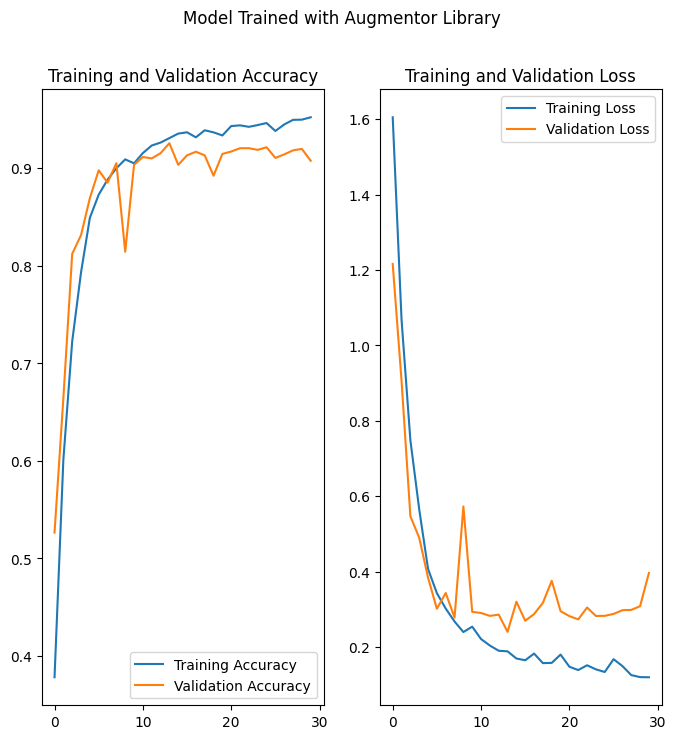

In [62]:
#Visualising the final Model results

acc = model_final_fitted.history['accuracy']
val_acc = model_final_fitted.history['val_accuracy']

loss = model_final_fitted.history['loss']
val_loss = model_final_fitted.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.suptitle('Model Trained with Augmentor Library')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Training Accuracy Trend**: The training accuracy steadily increases throughout the epochs, reaching approximately 95.21% accuracy by the end of the 30th epoch.

**Validation Accuracy Trend**: The validation accuracy also shows an increasing trend, reaching around 90.75% accuracy by the end of the training. However, there might be some fluctuations observed during the training process.

**Training Loss Trend**: The training loss consistently decreases with each epoch, indicating that the model is learning and improving its performance on the training data.

**Validation Loss Trend**: The validation loss initially decreases but then starts to increase after a certain point, indicating that the model might be overfitting to the training data. This increase in validation loss suggests that the model's performance on unseen data (validation set) might be degrading.

**Model Performance**: Overall, the model seems to be performing well on the training data, achieving high accuracy. However, there might be some concerns about overfitting, as indicated by the increasing validation loss.